# 주제 선정

- 출입국 데이터 중 관광 컬럼에 집중


- 주제: 태국 관광객을 대상으로 여행 장소 및 아이템 선정에 도움줄 수 있는 대시보드를 제작하고 분석에 기반한 홍보 포스터를 제작


- 사용한 데이터(6): 출입국 데이터, 한국 여행 중 방문권역 - 1년 이하, 외래 관광객 실태 조사, 서울시 관광특구 데이터 정보, 서울시 자랑스러운 한국음식점 정보, 서울시 관광거리 정보

# 출입국 데이터 병합

In [5]:
# 2010-01 ~ 2020-05 출입국 데이터 하나로 병합
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyreadstat

import warnings 
warnings.filterwarnings(action='ignore') #경고 문구 무시


def foreign_data(yy, mm):
# 1. 불러올 엑셀 파일 경로 지정
    file_path = './출입국 data/foreign_{}{}.xlsx'.format(yy, mm)
# 2. 엑셀 파일 불러오기
    im = pd.read_excel(file_path, header = 1, skipfooter = 4) #skipfooter 아래에서 4개 행 없애기 
# 3. '기준년월' 컬럼 추가
    im['기준년월'] = '{}-{}'.format(yy, mm)

    return im

# 6자리로 정렬하여 기준년월 출력하기 
for yy in range(2014, 2020):
    for mm in range(1, 13):
        mm_str = str(mm).zfill(2)   
# zfill을 적용하여 한 자리수 달도 0을 붙여 두 자리수로 변환
        yymm = '{}{}'.format(yy, mm)
    
im = pd.DataFrame()

for yy in range(2014, 2020):
    for mm in range(1, 13):
        tmp = foreign_data(str(yy), str(mm).zfill(2))
        im = im.append(tmp, ignore_index = True)
#im['국적'].unique() -> 국적에 대륙전체가 합계가 포함된 행 삭제 필요성 발견

In [6]:
#'주' 인것 제외 
temp=(im["국적"].isin(['아시아주','구주','미주','대양주','아프리카주','기타대륙','교포소계'])==False)
im = im.loc[temp]

In [7]:
# 국적별 관광객 합계를 확인
im.groupby('국적')['관광'].sum().sort_values(ascending = False).head(6)

국적
중국    28145212
일본    14395556
대만     5191604
미국     4019338
홍콩     3690880
태국     2493817
Name: 관광, dtype: int64

너무나 당연한 1,2위 중국과 일본을 제외하고 의외의 고순위 나라를 선택

중국 인구의 1/20 이지만 출입국 수 자체는 1/10배, 전체 6위에 해당

# 출입국 데이터 전처리

In [8]:
#열 이름 변경
im.rename({'국적':'ctr', '관광':'tour','상용':'cb','공용':'ob', '유학/연수':'study','기타':'ect','계':'total','전년동기':'yoy','성장률(%)':'growth','구성비(%)':'ratio','기준년월':'date'},axis=1, inplace=True)

In [9]:
# date 열을 이용한 season 컬럼 추가
im['season'] = im['date'].str[-2:]
sea = {"01":"winter", "02":"winter", "03":"spring","04":"spring", "05":"spring", "06":"summer", "07":"summer",
      "08":"summer", "09":"fall", "10":"fall", "11":"fall", "12":"winter"}
im['season'] = im['season'].map(sea)
im[:1]

,ctr,tour,cb,ob,study,ect,total,yoy,growth,ratio,date,season
1,일본,164038,2564,81,720,4674,172077,206474,-16.7,20.4,2014-01,winter


In [ ]:
#태블로 시각화를 위한 파일 저장
sel.to_csv('sel.csv', encoding = 'cp949')

# 태국 관광객의 주요 방문 권역

태국관광객이 우리나라에서 주로 어느 지역을 방문하는지를 확인하기 위해 외부 데이터를 사용

In [14]:
ThaiSeoul = pd.read_csv('ThaiSeoul.csv', encoding = 'cp949')
ThaiSeoul[:2]

,통계분류(1),통계분류(2),시점,사례수,서울,경기도,인천,강원도,충청도,경상도,전라도,제주,기타
0,전체,소계,2014,12024,80.4,13.0,5.0,7.1,2.4,10.8,2.8,18.0,0.2
1,전체,소계,2015,12882,78.7,13.3,6.8,6.4,3.0,13.0,3.4,18.3,0.1


In [15]:
#국가가 태국인 행 추출
ThaiSeoul = ThaiSeoul.iloc[108:114, [2,4,5,6,7,8,9,10,11,12]] 
ThaiSeoul = ThaiSeoul.set_index('시점')
ThaiSeoul

,서울,경기도,인천,강원도,충청도,경상도,전라도,제주,기타
시점,,,,,,,,,
2014,98.7,39.4,10.2,48.4,1.4,3.2,0.5,1.0,0.3
2015,88.1,28.6,11.6,24.8,2.5,9.0,2.4,9.1,0.2
2016,87.5,27.8,10.4,28.0,3.0,9.5,1.3,8.8,0.5
2017,90.4,24.0,13.5,16.4,1.2,17.2,1.6,2.2,0
2018,84.5,21.6,12.6,19.0,4.4,18.8,1.8,7.7,-
2019,75.5,42.0,15.7,21.2,2.2,15.2,1.0,10.8,-


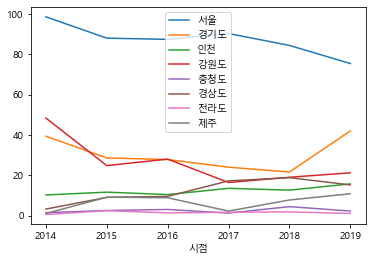

In [16]:
#방문 지역 시각화
ThaiSeoul.plot() 
plt.rc('font', family='Malgun Gothic')
#서울을 대부분 방문

# 태국인 중 특정 연령 및 성별 타겟팅(R 전처리)

태국인 중 타겟팅 대상을 선정하고 좋아하는 활동, 장소등을 파악하기 위해 외부 데이터 활용
-> r로 전처리

In [17]:
### 추가 전처리
# r studio에서 하나로 bind한 데이터를 다시 jupyter로 로드
# 변수 이름 뿐만 아니라 변수 값도 통일되어 있지 않아 map,lambda로 통일
real1419 = pd.read_csv("real1419.csv", encoding = 'cp949')
gen = {"남자":"male","남성":"male", "여자":"female","여성":"female"}
ag = {"15~20세":"15-20","15-20세":"15-20", "21~30세":"21-30", "21-30세":"21-30", "31~40세":"31-40", "31-40세":"31-40", "41~50세":"41-50", "41-50세":"41-50", "51~60세":"51-60", "51-60세":"51-60", "61세이상":"61+", "모름/무응답":"unknown"}
real1419['sex'] = real1419['sex'].map(lambda x: gen.get(x,x))
real1419['age'] = real1419['age'].map(lambda x: ag.get(x,x))
real1419[:1]

,Unnamed: 0,country,purpose,favact,favplace1,favplace2,favplace3,sitem1,sitem2,sitem3,splace1,splace2,splace3,expense,sex,age,year
0,1,태국,"여가, 위락, 개별휴가",쇼핑,한라산,성산일출봉,동대문시장,"향수, 화장품","인삼, 한약재",NaN,동대문시장,이태원시장,NaN,1064.0,male,41-50,2014


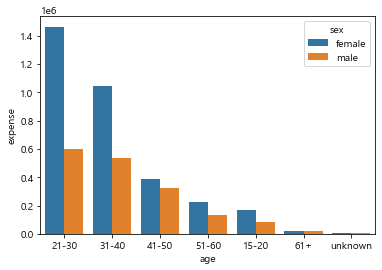

In [18]:
# 특정 나이대 및 성별을 타겟팅 하기 위한 여행 지출 비용 합계 추출 및 시각화
target = real1419.groupby(['age','sex'])['expense'].sum().sort_values(ascending=False).reset_index()
fig = sns.barplot(data = target, x = 'age', y = 'expense', hue='sex')

세부 타겟팅: 21-40세 태국인 여성 관광객

### 타켓팅 대상이 여행 중 가장 만족했던 활동 top 4 추출 및 시각화

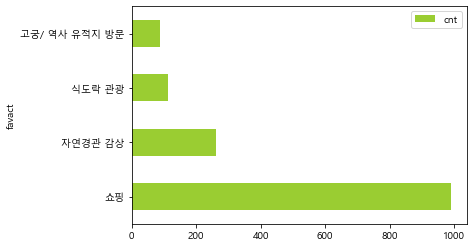

In [19]:
f2140 = real1419.query('( age == "21-30" or age == "31-40" ) and sex == "female" ')
f2140 = f2140.iloc[:, 1:] #필요 없는 행 제거
fav = f2140.groupby('favact').size().sort_values(ascending=False)[:4] #4가지 활동
fav = fav.reset_index(name = "cnt")
fav.plot(kind='barh', x = 'favact', y = 'cnt', color = "yellowgreen")
plt.rc('font', family='Malgun Gothic')

In [182]:
#태블로 시각화를 위한 파일 저장
f2140.to_csv('f2140.csv', encoding = 'cp949')

결론

태국인은 주로 서울권역에서 여행하며 주요 관광객은 21~40세 여성이다.
가장 좋아하는 활동은 쇼핑으로 파악되었다.

위 분석을 바탕으로 태블로에서 여행 상품 기획을 위한 대시보드를 제작하여 인사이트를 얻을 수 있도록 하였다.

방문지와 활동, 여행 시기(계절), 쇼핑 장소와 품목의 전체적인 시각화를 위해 태블로 사용